In [75]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None  )
pd.set_option('display.max_colwidth', None)

from scipy.optimize import curve_fit

def samples_seen_from_str(samples):
    if samples.endswith("M"):
        samples = float(samples[:-1]) * 10**6
    elif samples.endswith("B"):
        samples = float(samples[:-1]) * 10**9
    elif samples.endswith("K"):
        samples = float(samples[:-1]) * 10**3
    return samples

def powlaw_irreducible(x, a, b, c):
    return a * np.power(x, b) + c


def powlaw_chinchilla(x, a, alpha, b, c):
    # x is tuple n, d
    return c + a * np.power(x[0], alpha) + b * np.power(x[1], alpha)

def powlaw(x, a, b):
    return a * np.power(x, b)


def curve_fit_powlaw_irreducible(xdata, ydata):
    # try many different fits and retain the best one as done in chinchilla
    a_p0 = [5e1, 5e2, 5e3]
    b_p0 = [-1e-1]
    c_p0 = [0.0]

    min_residual = float("inf")
    ret = None

    for a0 in a_p0:
        for b0 in b_p0:
            for c0 in c_p0:
                popt, pcov = curve_fit(
                    powlaw_irreducible,
                    xdata,
                    ydata,
                    p0=[a0, b0, c0],
                    maxfev=10000,
                )

                ydatafit = powlaw_irreducible(xdata, *popt)
                residuals = ydata - ydatafit
                curr_residual = (np.sum(residuals**2) / (residuals.size - 2)) ** 0.5

                if curr_residual < min_residual:
                    min_residual = curr_residual
                    ret = (popt, pcov, ydatafit)

    def func(x):
        a,b,c = ret[0]
        return (a*x**b+c)
    a,b,c = ret[0]
    return (a,b,c), func, f"Y = {a:.2f}*X^{b:.2f}+{c:.2f}"

def curve_fit_powlaw_quantile(xdata, ydata, q=0.1):
    from sklearn.linear_model import QuantileRegressor, LinearRegression
    if q is None:
        r = LinearRegression()
    else:
        r = QuantileRegressor(quantile=q, alpha=0, solver='highs-ds')
    print(r)
    log_xdata = np.log(xdata)
    log_ydata = np.log(ydata)
    r.fit(log_xdata.reshape((-1, 1)), log_ydata)
    def func(x):
        return (x**r.coef_[0]) * np.exp(r.intercept_)
    a, b = (r.intercept_, r.coef_[0])
    return (a,b), func, f"Y = {np.exp(a):.2f} x X^{b:.2f}"

In [2]:
%%time
!python build_results_dataframe.py

CPU times: user 2.5 s, sys: 415 ms, total: 2.92 s
Wall time: 3min 45s


In [ ]:
model_profile = pd.read_csv("model_profile.csv").set_index("model")
df = pd.read_csv("results.csv")

In [ ]:
scales = [
    "1.28M",
    "3M",
    "6.4M",
    "12.8M",
    "30M",
    "64M",
    "128M",
    "300M",
    "1.28B",
    "3B",
    "12.8B",
]
def human(v):
    # check closest from `scales`
    for s in reversed(scales):
        if v >= samples_seen_from_str(s):
            return s
    else:
        if v < 10 ** 6:
            return str(v)
        elif v > 10**6 and v < 10**9:
            return (str(v/10**6)+"M").replace(".0M", "M")
        elif v > 10**9:
            return (str(v/10**9)+"B").replace(".0B", "B")

df["samples_seen_scale_simple"] = df.total_samples_seen.apply(lambda s:human(s))
df.samples_seen_scale_simple.unique()

array(['1.28M', '1.28B', '12.8M', '128M', '12.8B', '3B', '64M', '3M',
       '300M', '6.4M', '30M'], dtype=object)

In [77]:
df.columns

Index(['path', 'model', 'pretrain_dataset', 'downstream_dataset', 'epoch',
       'total_epochs', 'name', 'gflops_total', 'samples_per_sec',
       'samples_per_sec_per_gpu', 'global_batch_size', 'training_time_hours',
       'gpus', 'total_steps', 'task', 'local_batch_size', 'warmup', 'lr',
       'lr_scheduler', 'contrastive_loss', 'caption_loss', 'namespace',
       'eval_type', 'gpu_hours', 'image_acc', 'text_acc', 'acc', 'acc1',
       'acc5', 'mean_per_class_recall', 'image_retrieval_recall@5',
       'text_retrieval_recall@5', 'name_epoch', 'samples_seen_scale_simple',
       'model_simple', 'model_simple_namespace'],
      dtype='object')

In [108]:
print("Number of unique models: ", len(df.name.unique()))
print("Number of unique checkpoints: ", len(df.name_epoch.unique()))
print("Number of downstream datasets", len(df.downstream_dataset.unique()))
print("Number of evaluations", len(df))

Number of unique models:  1559
Number of unique checkpoints:  34256
Number of downstream datasets 11
Number of evaluations 134483


# Throughput 

<Axes: xlabel='model_s', ylabel='normalized_samples_per_sec_per_gpu'>

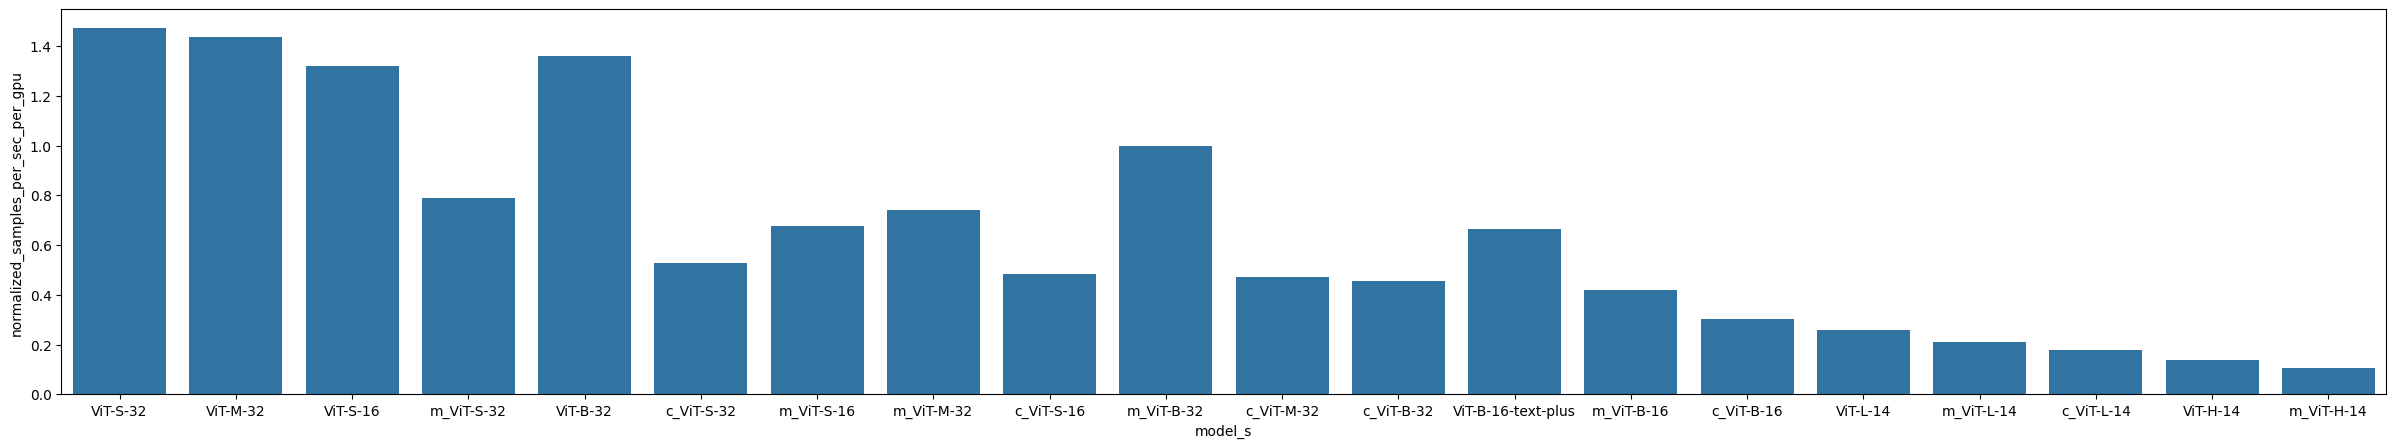

In [79]:
fig = plt.figure(figsize=(30, 5))
d = df.copy()
d["model_s"] = d.model.apply(lambda m:m.replace("mammut", "m").replace("coca", "c"))
archs = d.model_s.unique()
archs = sorted(archs, key=lambda k:model_profile.loc[k.replace("m", "mammut").replace("c", "coca")].gflops)

d["normalized_samples_per_sec_per_gpu"] = d["samples_per_sec_per_gpu"] / (d["local_batch_size"] * d["gpus"]) 
sns.barplot(x="model_s", y="normalized_samples_per_sec_per_gpu", data=d, order=archs, estimator=np.max)

In [80]:
d = df.copy()
d["normalized_samples_per_sec_per_gpu"] = d["samples_per_sec_per_gpu"] / (d["local_batch_size"] * d["gpus"]) 
d.groupby("model_simple_namespace").max("samples_per_sec_per_gpu").samples_per_sec_per_gpu.sort_values()

model_simple_namespace
ViT-H-14_mammut              55.467589
ViT-H-14_cap                 65.918173
ViT-H-14_clip                74.115664
ViT-L-14_coca               107.178987
ViT-L-14_mammut             118.440348
ViT-L-14_cap                135.658584
ViT-L-14_clip               149.465855
ViT-B-16_coca               195.494934
ViT-B-16_mammut             252.852082
ViT-B-16_cap                294.591618
ViT-B-32_coca               313.512217
ViT-M-32_coca               327.108849
ViT-S-16_coca               338.673007
ViT-S-32_coca               380.128967
ViT-B-16-text-plus_clip     436.032583
ViT-S-16_mammut             480.001876
ViT-B-32_mammut             491.509814
ViT-M-32_mammut             520.326020
ViT-S-16_cap                528.224919
ViT-B-32_cap                554.248881
ViT-M-32_cap                586.268684
ViT-S-32_mammut             591.415351
ViT-S-32_cap                645.252519
ViT-S-16_clip               884.322854
ViT-B-32_clip               919.224325
Vi

# DataComp Recap (recaptioned) vs DataComp results

In [81]:
#ds = "imagenet1k"
#metric = "acc1"

#ds = "sugar_crepe/swap_obj"
#metric = "acc"

ds = "winoground"
metric = "image_acc"


pretrain_datasets = df.pretrain_dataset.unique()
print(pretrain_datasets)

d = df[~df.pretrain_dataset.isna()].copy()
d["name_wo_ds"] = d.name.apply(lambda n:n.replace("datacomp_recap", "").replace("datacomp", ""))


df_recap = d[d.pretrain_dataset.str.contains("recap")]
df_orig = d[~d.pretrain_dataset.str.contains("recap")]


d = df_recap
d = d[d.epoch == d.total_epochs]
d = d[d.downstream_dataset == ds]


do = df_orig
do = do[do.epoch == do.total_epochs]
do = do[do.downstream_dataset == ds]
d = pd.merge(d, do, on="name_wo_ds", suffixes=("_recap", "_orig"))
d[["name_recap", f"{metric}_recap", f"{metric}_orig"]]

['/p/data1/mmlaion/datacomp/datacomp_1B/flat/{0000000..0139827}.tar'
 '/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/{0000000..0139827}.tar'
 '/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar'
 nan]


,name_recap,image_acc_recap,image_acc_orig
0,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1950,0.1550
1,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2125,0.1550
2,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2325,0.1575
3,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2000,0.1375
4,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2000,0.1400
5,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1900,0.1700
6,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1925,0.1700
7,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1900,0.1550
8,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2175,0.1350
9,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2175,0.1625


# Results per checkpoint

In [82]:
df[df.downstream_dataset=="imagenet1k"].sort_values(by="acc1", ascending=False).head()[["acc1", "name", "namespace", "epoch"]]

,acc1,name,namespace,epoch
106421,0.80342,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,99
106397,0.80338,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,100
106285,0.80298,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
106420,0.80294,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,98
79170,0.80232,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,98


In [83]:
d = df
d = d[d.downstream_dataset=="imagenet1k"]
d = d[d.epoch==d.total_epochs]
d = d[d.samples_seen_scale_simple=="12.8B"]
d = d[d.model_simple=="ViT-L-14"]
d = d.sort_values(by="acc1", ascending=False)[["acc1", "name", "namespace"]]
d

,acc1,name,namespace
106397,0.803380,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
94565,0.802260,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
79147,0.801680,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
70632,0.801520,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
48284,0.800700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
104779,0.800280,datacomp_s12.8B_bs_360960_mammut_ViT-L-14_ep100_lr0.0035_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n320_bs282_sigFalse,mammut
83195,0.799060,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0015_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
85519,0.798600,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n176_bs128_sigFalse,mammut
78947,0.796100,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n176_bs128_sigFalse,mammut
85719,0.793400,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut


In [84]:
df[df.downstream_dataset=="sugar_crepe"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
131257,0.910728,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,19
131265,0.910250,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,20
131262,0.905062,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,18
133492,0.903457,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,20
131275,0.903354,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,17


In [14]:
df[df.downstream_dataset=="sugar_crepe/swap_obj"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
70297,0.869919,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,92
70519,0.869919,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,100
70742,0.865854,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,97
8236,0.865854,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,19
70629,0.865854,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,99


In [ ]:
df[df.downstream_dataset=="winoground"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
48007,0.1425,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,88
4495,0.1400,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
47901,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,99
47990,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
4381,0.1375,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,20


In [ ]:
df[df.downstream_dataset=="winoground"].sort_values(by="text_acc", ascending=False).head()[["text_acc", "name", "namespace", "epoch"]]

,text_acc,name,namespace,epoch
70375,0.380,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,40
70649,0.370,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,70
70492,0.370,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,93
70685,0.365,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,94
70646,0.360,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,91


In [ ]:
df[df.downstream_dataset=="winoground"].sort_values(by="image_acc", ascending=False).head()[["image_acc", "name", "namespace", "epoch"]]

,image_acc,name,namespace,epoch
9837,0.2475,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,19
9748,0.2425,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,16
21614,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
10086,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,6
2076,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,13


In [18]:
df[df.downstream_dataset=="winoground"].sort_values(by="image_acc", ascending=False).head()[["image_acc", "name", "namespace", "epoch"]]

,image_acc,name,namespace,epoch
9837,0.2475,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,19
9748,0.2425,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,16
21614,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
10086,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,6
2076,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,13


# Specific Training Curves

       epoch  text_acc
48461      1    0.0325
48011      2    0.0225
48115      3    0.0550
48219      4    0.0850
48363      5    0.1050
47897      6    0.0925
48455      7    0.1350
47909      8    0.1650
48367      9    0.1575
47870     10    0.1650
48021     11    0.1950
48432     12    0.1875
48026     13    0.1700
47985     14    0.2075
48143     15    0.2125
47996     16    0.2050
48174     17    0.1750
48318     18    0.2375
48148     19    0.2225
47980     20    0.2100
48008     21    0.2125
48181     22    0.2150
48084     23    0.2000
48133     24    0.2350
48010     25    0.2200
48249     26    0.2175
47940     27    0.2400
48443     28    0.2100
48129     29    0.2125
48150     30    0.2550
47958     31    0.2225
47968     32    0.2250
48436     33    0.2425
48232     34    0.2150
48366     35    0.2275
47972     36    0.2250
48246     37    0.2450
47946     38    0.2325
48141     39    0.2475
47956     40    0.2575
48454     41    0.2625
48111     42    0.2550
48370     4

<Axes: xlabel='epoch'>

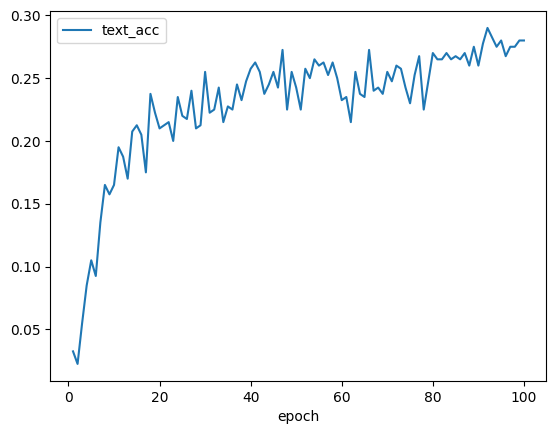

In [18]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1"

ds = "winoground"
metric = "text_acc"
task = "generative_image_caption_selection"

#ds = "sugar_crepe/swap_obj"
#metric = "acc"
#task = "generative_image_caption_selection"

#ds = "imagenet1k"
#metric = "acc1"
#task = "zeroshot_classification"
#task = "generative_zeroshot_classification"
d = df

d = d[d.name==name]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
print(d[["epoch", metric]])
d.plot(x="epoch", y=metric)
#d[["epoch", metric]]

<Axes: xlabel='epoch', ylabel='acc1'>

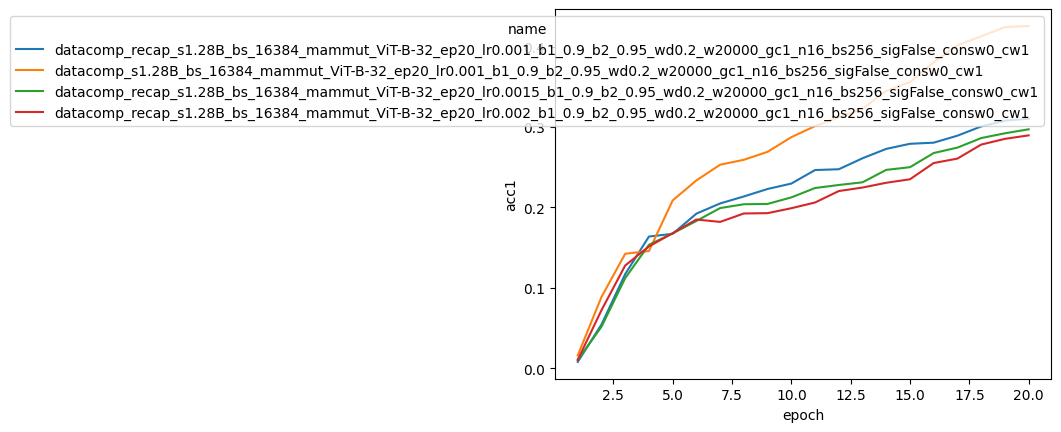

In [19]:
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"
names = [
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",

    "datacomp_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
]

#ds = "winoground"
#metric = "acc"
#task = "generative_image_caption_selection"

#ds = "sugar_crepe/add_obj"
#metric = "acc"
#task = "generative_image_caption_selection"

ds = "imagenet1k"
metric = "acc1"
#task = "zeroshot_classification"
task = "generative_zeroshot_classification"
d = df

d = d[d.name.isin(names)]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="name", data=d)
#d[["epoch", metric]]

<Axes: xlabel='epoch', ylabel='text_acc'>

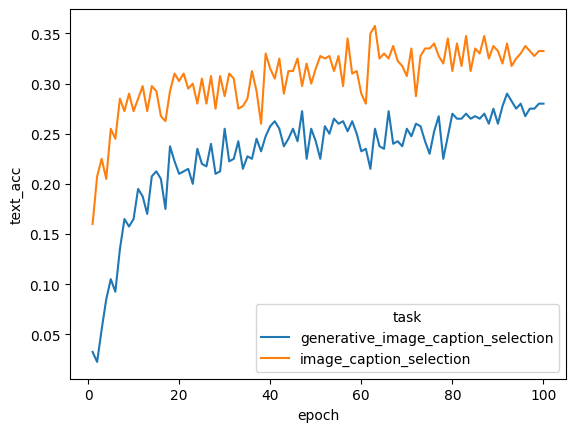

In [19]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "text_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)

<Axes: xlabel='epoch', ylabel='image_acc'>

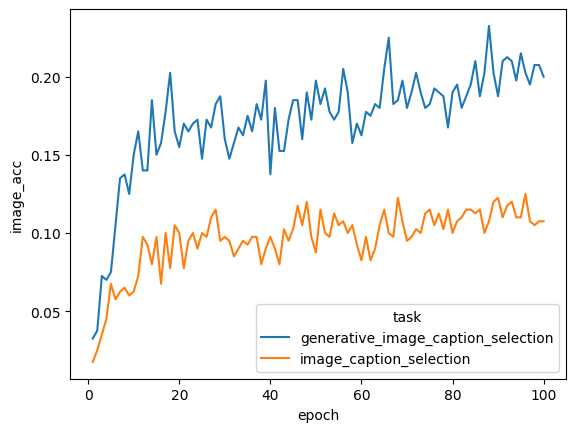

In [20]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "image_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)

In [48]:
print(df.pretrain_dataset.unique())

['/p/data1/mmlaion/datacomp/datacomp_1B/flat/{0000000..0139827}.tar'
 '/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/{0000000..0139827}.tar'
 '/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar'
 nan]


# Full results table

In [89]:
print(df.samples_seen_scale_simple.unique())

['1.28M' '1.28B' '12.8M' '128M' '12.8B' '3.072B' '64M' '3.072M' '640M'
 '307.2M' '6.4M' '30.72M' '2.9952B']


In [ ]:
d = df
d = d[d.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]
#ds = 'sugar_crepe/swap_obj'
#metric = "acc"

#ds = "winoground"
#metric = "text_acc"

#ds = "mscoco_captions"
#metric = "image_retrieval_recall@5"
#metric = "text_retrieval_recall@5"

ds = "imagenet1k"
metric = "acc1"

#eval_type = "log_likelihood"
#eval_type = "similarity"
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
#d = d[d.task.str.contains("generative")]
#print(len(d))
#d = d[d.eval_type == eval_type]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_simple", "model_simple_namespace")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("model_simple_namespace"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-1])].gflops)
#cols = [c  for c in cols if "cap" not in c and "coca" not in c and "H-14" not in c and "plus" not in c]

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
#index = ['1.28B']
d = d.loc[index]
#print(index)
#d = d.dropna(axis=0)
#d.T

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_simple,1.28M,3M,6.4M,12.8M,30M,64M,128M,300M,1.28B,3B,12.8B
model_simple_namespace,,,,,,,,,,,
ViT-S-32_cap,0.002769,NaN,NaN,0.044304,NaN,NaN,0.163172,NaN,0.305973,NaN,NaN
ViT-S-32_clip,0.013040,0.03032,NaN,0.102080,0.18664,NaN,0.354020,0.43956,0.557420,0.55864,0.59442
ViT-S-32_coca,0.015120,0.03340,NaN,0.113140,0.20104,NaN,0.358120,0.44002,NaN,NaN,NaN
ViT-S-32_mammut,0.014520,0.03340,0.06400,0.113840,0.20358,0.29304,0.372280,0.50264,0.514200,0.56516,NaN
ViT-M-32_cap,0.003362,NaN,NaN,0.042326,NaN,NaN,0.204114,NaN,0.364715,NaN,NaN
ViT-M-32_clip,0.013960,0.03240,NaN,0.105040,0.20074,NaN,0.383020,0.47810,0.603760,0.60788,0.63916
ViT-M-32_coca,0.016000,0.03114,NaN,0.119780,0.21860,NaN,0.388160,0.47972,NaN,NaN,NaN
ViT-M-32_mammut,0.013880,0.03344,0.06720,0.119640,0.22288,0.31810,0.403660,0.55098,0.570700,0.61362,NaN
ViT-S-16_cap,0.005340,NaN,NaN,0.060324,NaN,NaN,0.204312,NaN,0.351859,NaN,NaN


In [110]:
df.lr_scheduler.unique()

array(['cosine', 'const', 'const-cooldown'], dtype=object)

# Const-LR results

In [112]:
d = df.copy()
d["model_simple_namespace_scheduler"] = d.apply(lambda r:f"{r.model_simple_namespace}_{r.lr_scheduler}", axis=1)
d = d[d.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]
#ds = 'sugar_crepe/swap_obj'
#metric = "acc"

#ds = "winoground"
#metric = "text_acc"

#ds = "mscoco_captions"
#metric = "image_retrieval_recall@5"
#metric = "text_retrieval_recall@5"

ds = "imagenet1k"
metric = "acc1"

#eval_type = "log_likelihood"
#eval_type = "similarity"
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
#d = d[d.task.str.contains("generative")]
#print(len(d))
#d = d[d.eval_type == eval_type]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_simple", "model_simple_namespace_scheduler")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("model_simple_namespace_scheduler"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-2])].gflops)
#cols = [c  for c in cols if "cap" not in c and "coca" not in c and "H-14" not in c and "plus" not in c]

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
#index = ['1.28B']
d = d.loc[index]
#print(index)
#d = d.dropna(axis=0)
#d.T

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_simple,1.28M,3M,6.4M,12.8M,30M,64M,128M,300M,1.28B,3B,12.8B
model_simple_namespace_scheduler,,,,,,,,,,,
ViT-S-32_cap_cosine,0.002769,NaN,NaN,0.044304,NaN,NaN,0.163172,NaN,0.305973,NaN,NaN
ViT-S-32_clip_const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50304
ViT-S-32_clip_const-cooldown,NaN,NaN,NaN,NaN,NaN,NaN,0.075720,NaN,0.557420,NaN,0.59442
ViT-S-32_clip_cosine,0.013040,0.03032,NaN,0.102080,0.18664,NaN,0.354020,0.43956,0.531180,0.55864,NaN
ViT-S-32_coca_cosine,0.015120,0.03340,NaN,0.113140,0.20104,NaN,0.358120,0.44002,NaN,NaN,NaN
ViT-S-32_mammut_cosine,0.014520,0.03340,0.06400,0.113840,0.20358,0.29304,0.372280,0.50264,0.514200,0.56516,NaN
ViT-M-32_cap_cosine,0.003362,NaN,NaN,0.042326,NaN,NaN,0.204114,NaN,0.364715,NaN,NaN
ViT-M-32_clip_const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54558
ViT-M-32_clip_const-cooldown,NaN,NaN,NaN,NaN,NaN,NaN,0.089780,NaN,0.603760,NaN,0.63916


# Difference between Log-likehood and Similarity based evaluation

     generative_zeroshot_classification  zeroshot_classification     delta  \
50                             0.688739                  0.80070  0.111961   
150                            0.429188                  0.65380  0.224612   
151                            0.398318                  0.63082  0.232502   
1                              0.404991                  0.61630  0.211309   
0                              0.401335                  0.61618  0.214845   

     gflops_total  
50   2.685952e+12  
150  8.398848e+10  
151  8.398848e+10  
1    3.499520e+10  
0    3.499520e+10  


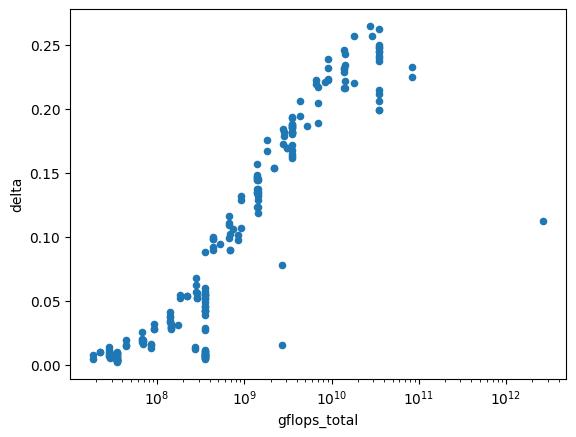

In [91]:
d = df.copy()
d = d[d.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]

#ds = 'sugar_crepe/swap_obj'
#metric = "acc"
#task = "image_caption_selection"

#ds = "winoground"
#metric = "text_acc"
#task = "image_caption_selection"

ds = "imagenet1k"
metric = "acc1"
task = "zeroshot_classification"

gtask = "generative_" + task

d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
di = d[d.task==task]
d["name_wo_task"] = d.apply(lambda r:r["name"].replace("generative_", ""), axis=1)
d = d.drop_duplicates(subset=["name_wo_task", "task"], keep="first")    
d = pd.pivot(
    d,
    index="name_wo_task",
    columns=("task"),
    values=metric,
)
d = d.dropna(axis=0)
d["delta"] = (d[task] - d[gtask]).abs()
d = pd.merge(d, di, left_on='name_wo_task', right_on="name")
d = d.sort_values(by=task, ascending=False)#.head()
print(d[[gtask, task, "delta", "gflops_total"]].head())
d.plot(x="gflops_total", y="delta", kind="scatter")
plt.xscale('log',base=10)

# Scaling law figures

In [92]:
def monotonically_decreasing(x):
    m = []
    minval = float("inf")
    for xi in x:
        if xi < minval:
            m.append(True)
            minval = xi
        else:
            m.append(False)
    return np.array(m)

def monotonically_increasing(x):
    m = []
    maxval = float("-inf")
    for xi in x:
        if xi > maxval:
            m.append(True)
            maxval = xi
        else:
            m.append(False)
    return np.array(m)

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


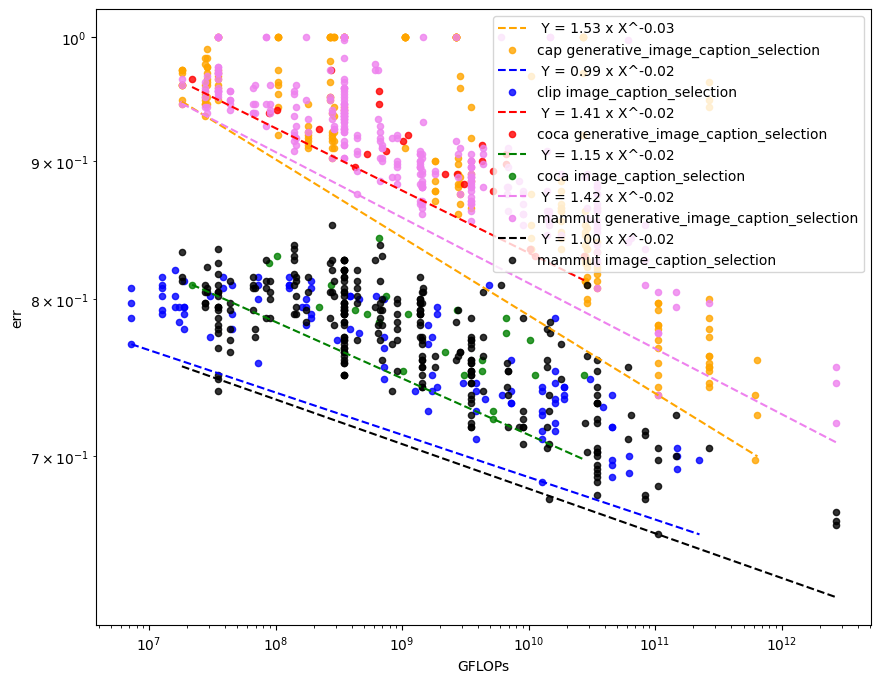

In [93]:
#ds = "winoground"
#metric = "image_acc"

ds = "winoground"
metric = "text_acc"

#ds = "sugar_crepe/swap_obj"
#metric = "acc"
#ds = "imagenet1k"
#metric = "acc1"

#ds = "mscoco_captions"
#metric = "image_retrieval_recall@5"

D = df
D = D[D.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]

D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows[rows.downstream_dataset==ds]
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = 1-(R[metric]).values


    color = colors[I]
    I+=1
    #m = (X>=10**9)# & (X < 10**12)
    #m = (X<10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    #print(np.unique(X))
    #for xi in np.unique(X):
    #    minval = Y[X==xi].min()
    #    Y[X==xi] = minval
    #m=(Y<=0.9) & (Y>0)
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)
    
    #X = X[Y<1]
    #Y = Y[Y<1]
    #m = monotonically_decreasing(Y)
    m = X>0
    plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]}", c=color, s=20.0, alpha=0.8)

    #plt.plot(X[m], Y[m], linestyle='dashed', c=color)
plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

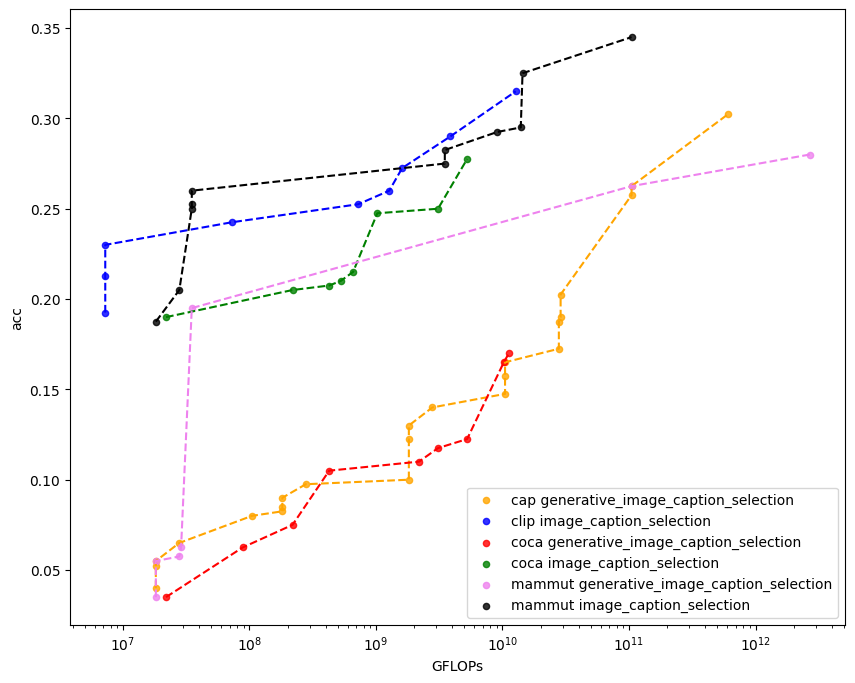

In [94]:
#ds = "sugar_crepe/swap_obj"
#metric = "acc"


#ds = "winoground"
#metric = "text_acc"

ds = "winoground"
metric = "text_acc"

#ds = "imagenet1k"
#metric = "acc1"

#ds = "mscoco_captions"
#metric = "image_retrieval_recall@5"

D = df
D = D[D.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]

D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows[rows.downstream_dataset==ds]
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    #Y = 1-(R[metric]).values
    Y = (R[metric]).values

    color = colors[I]
    I+=1
    #m = (X>=10**9)# & (X < 10**12)
    #m = (X<10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    #for xi in np.unique(X):
    #    minval = Y[X==xi].min()
    #    Y[X==xi] = minval
    #m=(Y<=0.9) & (Y>0)
    #coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    #plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)
    
    #X = X[Y<1]
    #Y = Y[Y<1]
    m = monotonically_increasing(Y)
    plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]}", c=color, s=20.0, alpha=0.8)

    plt.plot(X[m], Y[m], linestyle='dashed', c=color)
plt.xscale('log')
#plt.yscale("log")

plt.xlabel("GFLOPs")

#plt.ylabel("err")  
plt.ylabel("acc")
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


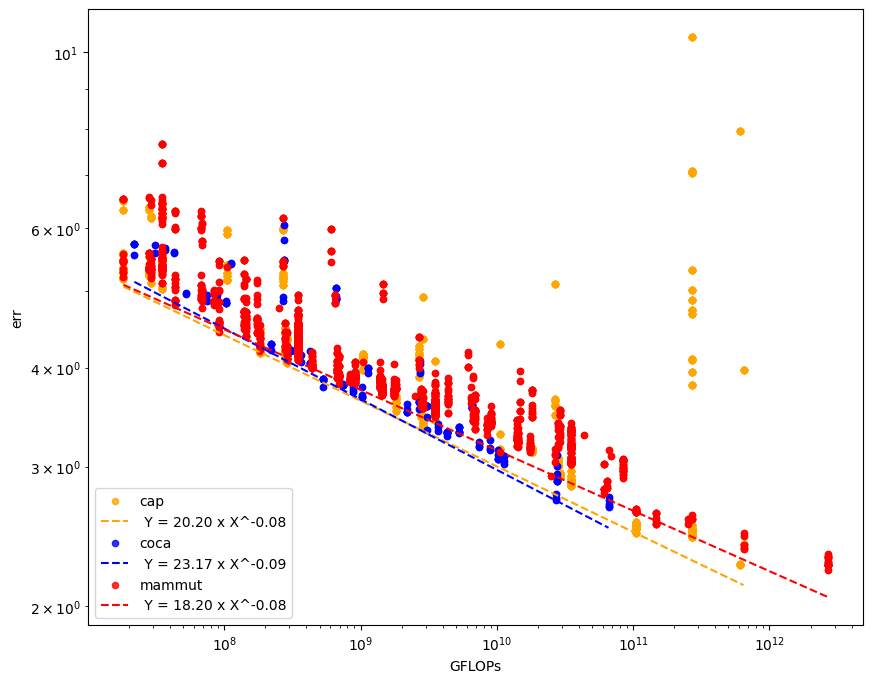

In [73]:
metric = "caption_loss"
D = df
D = D[D.pretrain_dataset != "/p/scratch/laionize/cherti1/datacomp_1B_recap/{0000000..0139827}.tar"]

D = D[D.epoch==D.total_epochs]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby("namespace")):  
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    #if "cap" in name:
    #    continue
    R = rows
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = (R[metric]).values
    color = colors[I]
    I+=1
    #m = (X>=10**8) & (X < 10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    plt.scatter(X[m], Y[m], label=f"{name}", c=color, s=20.0, alpha=0.8)
    #m=(Y<=0.9) & (Y>0)
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

plt.savefig(metric+".pdf")
plt.show()

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


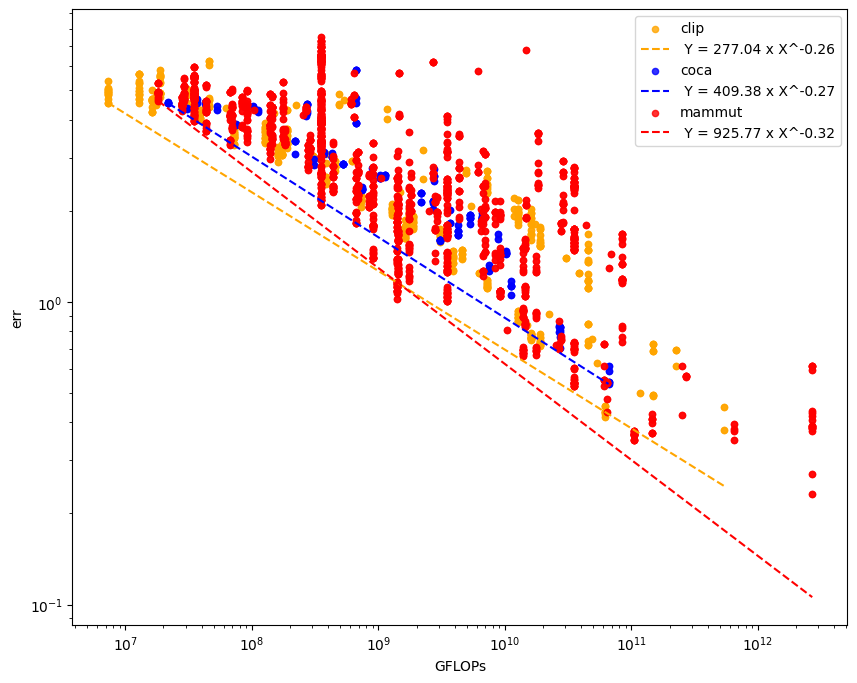

In [74]:
metric = "contrastive_loss"
D = df
D = D[D.epoch==D.total_epochs]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby("namespace")):  
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    #if "cap" in name:
    #    continue
    R = rows
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    if name == "cap":
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = (R[metric]).values
    color = colors[I]
    I+=1
    #m = (X>=10**8) & (X < 10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    plt.scatter(X[m], Y[m], label=f"{name}", c=color, s=20.0, alpha=0.8)
    #m=(Y<=0.9) & (Y>0)
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

plt.savefig(metric+".pdf")
plt.show()